# Exploitation - Edge Prediction

In the exploitation task, we aim to predict the edges and the type of edges (transport routes). We start with Hand crafted features, followed by node embedding and finally use GNNs. In this notebook, we will work using the hand-crafted features.

## Task - 1

In the first task, we predict the edges between the given nodes only when considering a single route type. 

### Node2vec features

To compute the edge features between nodes, we combine the node features by subtracting the source node features from the target node features and then add the edge features.

**Imports**

In [1]:
import glob
import pickle
import pathlib
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns

from enum import Enum
from tqdm import tqdm
from typing import Union, List, Dict, Literal, Tuple
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

from node2vec import Node2Vec

/Users/ravinithesh/miniconda3/envs/nml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Paths for input and output**

In [2]:
rel_data_folder_path = pathlib.Path("./../../../data")
transport_data_path = rel_data_folder_path.joinpath('transport_data')
city_network = rel_data_folder_path.joinpath('network_graphs')
city_network_graphs = city_network.joinpath('graphs')
city_network_graphs_dir = city_network_graphs.joinpath('directed_graphs')
city_network_bones = city_network.joinpath('nodes-edges')

checkpoints_folder_path = rel_data_folder_path.joinpath("checkpoints")
city_network_graphs_dir_edge_pred_node2vec = checkpoints_folder_path.joinpath('node2vec-single-class')

rel_docs_folder_path = pathlib.Path("./../../../documents")
reports_folder_path = rel_docs_folder_path.joinpath("report")
tex_folder_path = reports_folder_path.joinpath("tex_files")
images_folder_path = tex_folder_path.joinpath("images")

**Utility Functions**

In [3]:
# Define enum for route types
class RouteType(Enum):
    """
    An enumeration class representing different types of routes.

    Possible values:
    - tram
    - subway
    - rail
    - bus
    - ferry
    - cablecar
    - gondola
    """
    tram, subway, rail, bus, ferry, cablecar, gondola = range(7)

def load_city_graphs(city_name, graphs_folder):
    """
    Load the graph representation of a city from a file.

    Args:
        city_name (str): The name of the city.
        graphs_folder (pathlib.Path): The folder where the graph files are located.

    Returns:
        dict: A dictionary with key as the route type and value as the graph representation of the route network.
    """
    with open(graphs_folder.joinpath(city_name.lower() + '.gpickle'), 'rb') as f:
        city_graph = pickle.load(f)
    return city_graph

def load_all_cities_graphs(cities: list[str], graphs_folder: pathlib.Path):
    """
    Load the graph representations of multiple cities.

    Args:
        cities (list[str]): A list of city names.
        graphs_folder (pathlib.Path): The folder where the graph files are located.

    Returns:
        dict: A dictionary mapping city names to their dictionery of graph representations.
    """
    return {city: load_city_graphs(city, graphs_folder) for city in cities}

def Node2Vec_node_feature_extraction(graph: nx.Graph, num_features: int, p: float, q: float, seed: int) -> Dict[float, np.ndarray]:
    ''' 
    INPUT:
    graph: the graph
    num_features: dimension of node2vec embeddings, int
    p: float
    q: float
    seed: please always set to 0

    OUTPUT:
    features: feature matrix of dimensions (N, D) (N: number of samples; D: dimension of Node2Vec embeddings) 
    '''

    node2vec_ = Node2Vec(graph, dimensions=num_features, p=p, q=q, seed=seed)
    model = node2vec_.fit()
    features_dict = {node: model.wv[idx] for idx, node in enumerate(graph.nodes())}
    return features_dict

def generate_edge_feature_targets(graph: nx.Graph, num_features: int, p: float, q: float, seed: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate a node feature matrix for a given graph.

    Args:
        graph: The input graph.
        num_features: dimension of node2vec embeddings, int
        p: float
        q: float
        seed: Default to 0

    Returns:
        edge_features: The edge features.
        targes: target vector with values of {0, 1}
        labels: vector of all possible targets in the graph 

    """
    
    nodes = list(graph.nodes())
    num_nodes = len(nodes)
    
    edge_features = []
    targets = []
    
    node_features = Node2Vec_node_feature_extraction(graph, num_features=num_features, p=p, q=q, seed=seed)
    

    for idx1 in range(num_nodes):
        node1 = nodes[idx1]
        node_1_feat = node_features[node1]
        for idx2 in range(num_nodes):
            node2 = nodes[idx2]
            node_2_feat = node_features[node2]
            
            comb_feature = np.subtract(node_2_feat, node_1_feat)
            
            edge_features.append(comb_feature)
            targets.append(1 if graph.has_edge(node1, node2) else 0)
            
    return np.array(edge_features), np.array(targets), np.unique(targets)

def classifier(features: np.ndarray, targets: np.ndarray, labels: np.ndarray, feature_selection: bool=False, num_features: int=1, test_size: float=0.5, seed: int=0, verbose: bool=False, input_feature_names: List[str]=[], title: str='') -> Tuple[np.ndarray, float, float]:
    ''' 
    INPUT:
    features: feature matrix of dimensions (N, D) (N: number of samples; D: number of features) 
    targets: target vector of dimensions (N, ) (N: number of samples)
    labels: vector of all possible labels for nodes in the graph 
    feature_selection: a flag for whether to use feature selction, bool
    num_features: number of features used from feature selesction
    test_size: Size of the test set, float
    seed: please set to 0 for reproducibility
    verbose: print and plot result or not, bool
    input_feature_names: Names for the input features, None by default
    title: Title for the confusion matrix

    OUTPUT:
    cm: confusion matrix on the test set
    f1: weighted f1 score on the test set
    acc: accuracy score on the test set

    '''

    # Split the data into training and testing sets, with test_size
    X_train, X_test, y_train, y_test = train_test_split(features, targets, stratify=targets, random_state=seed, test_size=test_size)

    if feature_selection:
        ## Build and train the ML model, including feature selection, normalization and Support Vector Classifier. Select the k highest relevant features for the classification. 
        feature_selector = SelectKBest(f_classif, k=num_features)
        X_train_sel = feature_selector.fit_transform(X_train, y_train)
        clf = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', random_state=seed))
        clf.fit(X_train_sel, y_train)
        ## Print the scores for individual features.
        print("\nTo select the top {} features:".format(num_features))
        if not input_feature_names:
            input_feature_names = ["feature_{}".format(str(i)) for i in range(features.shape[1])]
        print("\tThe feature scorees are:")
        print("\t{}".format({ft_name:ft_score for ft_name, ft_score in zip(input_feature_names, feature_selector.scores_)}))
        print("\tThe selected features are {}".format(feature_selector.get_feature_names_out(input_features=input_feature_names)))
    else:
        ## Build and train the ML model, including normalization and Logi.
        clf = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', random_state=seed))
        clf.fit(X_train, y_train)

    # Use the model to predict the labels of the test data
    if feature_selection:
        X_test_sel = feature_selector.transform(X_test)
        y_pred = clf.predict(X_test_sel)
    else:
        y_pred = clf.predict(X_test)
    # Output the confusion matrix and weighted f1 score on the test set. Print the weighted f1 score and plot the confusion matrix if verbose
    cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')
    acc = metrics.accuracy_score(y_test, y_pred)

    if verbose:
        print("\t\tThe Weighted F1 score is {}".format(f1))
        print("\t\tThe Accuracy is {}".format(acc))
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        if title:
            disp.ax_.set_title(title)
        plt.show()
    return cm, f1, acc # type: ignore

def train_model(cities_graphs_dicts: Dict[str, Dict[str, Union[float, List[List[int]], nx.Graph]]], results_path: pathlib.Path, test_size: float, seed: int, num_features: int, p: float, q: float) -> None:
    
    '''
    INPUT:
    cities_graphs_dicts: dictionary with keys as city names and values as dictionaries with keys as route types and values as route graphs
    results_path: path to save the results
    test_size: size of the test set, float
    seed: please set to 0 for reproducibility
    num_features: dimension of node2vec embeddings, int
    p: float
    q: float
    
    OUTPUT:
    None
    
    '''
    
    results_path.mkdir(parents=True, exist_ok=True)

    for city, city_graphs in tqdm(cities_graphs_dicts.items()):
        city_graphs_scores = {}
        for route_type, route_graph in city_graphs.items():
            if ((route_type in ["full"]) or (route_graph is None)):
                city_graphs_scores[route_type] = {"f1": None, "cm": np.array([[0, 0], [0, 0]]), "acc": None}
                continue

            if ((route_type in ["bus"]) and (city in ["sydney"])):
                city_graphs_scores[route_type] = {"f1": None, "cm": np.array([[0, 0], [0, 0]]), "acc": None}
                continue
                
            features_edges, targets_edge, labels_edge = generate_edge_feature_targets(route_graph,
                                                                                      num_features=num_features,
                                                                                      p=p, q=q,
                                                                                      seed=seed)

            
            cm, f1score, accuracy = classifier(features_edges, targets_edge, labels_edge,
                                     feature_selection=False, test_size=test_size,
                                     seed=seed, verbose=False)

            city_graphs_scores[route_type] = {"f1": f1score, "cm": cm, "acc": accuracy}

        with open(results_path.joinpath('{}.gpickle'.format(city)), 'wb') as f:
            pickle.dump(city_graphs_scores, f, pickle.HIGHEST_PROTOCOL)
            
        print("Results saved")

def read_scores(results_path: pathlib.Path, modes_to_drop: List[str]) -> Tuple[Dict[str, Dict[str, Union[float, list[List[int]], nx.Graph]]], pd.DataFrame]:
    '''
    INPUT:
    results_path: path to read the results
    modes_to_drop: list of modes of transport to drop from the results
    
    OUTPUT:
    cities_graphs_scores: dictionary with keys as city names and values as dictionaries with keys as metric name and values as metrics
    cities_graphs_scores_df: dataframe with columns as city, route, metric name and metric value
    '''
    cities_reg = sorted([x.stem for x in results_path.glob('*.gpickle')])
    cities_graphs_scores = load_all_cities_graphs(cities_reg, results_path)
    cities_graphs_scores_df = pd.DataFrame.from_dict({(i,j): cities_graphs_scores[i][j] 
                           for i in cities_graphs_scores.keys() 
                           for j in cities_graphs_scores[i].keys()},
                       orient='index').reset_index(drop=False, names=['city', 'route'])
    
    if modes_to_drop:
        cities_graphs_scores_df = cities_graphs_scores_df[~cities_graphs_scores_df['route'].isin(modes_to_drop)]
    
    return cities_graphs_scores, cities_graphs_scores_df

def plot_cms(scores_dict: Dict[str, Union[float, List[List[int]], nx.Graph]], mode: str) -> None:
    '''
    Input
    scores_dict: dictionary with keys as city names and values as dictionaries with keys as metric name and values as metric
    mode: The mode of transport to use in the title
    '''
    
    fig, axes = plt.subplots(5, 5, figsize=(16, 16), sharex=False, sharey=False)
    labels = [0, 1]
    for idx, (city, city_scores_lr) in tqdm(enumerate(scores_dict.items())):

        row = int(idx / 5)
        col = idx % 5

        cm = city_scores_lr[mode]['cm']
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(ax=axes[row][col], values_format='')
        disp.ax_.set_title(city)

    fig.suptitle('Confusion Matrix for {} networks edge prediction (LogReg)'.format(mode))
    fig.tight_layout()

def plot_scores(scores_df: pd.DataFrame, num_features: int, score_string: Literal["f1", "acc"]="f1", features: str="all"):
    '''
    Input
    scores_df: Scores dataframe with columns city, route, and one column each for the F1 score, ConfusionMatrix and Accuracy
    num_features: dimension of node2vec embeddings, int
    score_string: The score string to plot.
    features: The features used to generate the scores
    '''
    plt.figure(figsize=(12,10))
    sns.scatterplot(data=scores_df, x="route", y=score_string, style="city", hue='city')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.title('{} score of edge prediction using {} {} features (LogReg)'.format(score_string, num_features, features))
    return plt.gcf()

**Setting the parameters**

In [4]:
seed = 0
test_size = 0.3
p = 1.0
q = 1.0
max_num_features = 10

**Reading the graphs for all the cities**

In [5]:
cities = sorted([x.stem for x in city_network_graphs_dir.glob('*.gpickle')])
cities_graphs_dir = load_all_cities_graphs(cities, city_network_graphs_dir)

## Modelling

We train a Logistic Regression model for each transport type in each city with 0:50 split of training and testing data. The sydney bus network is ignored as the memory is not sufficient for it.

Run the next cell to re run the training and save the accuracy, confusion matrix and the f1score. Otherwise, skip the next cell and run the cell after it to load the saved scores.

In [ ]:
for num_features in tqdm(range(1, max_num_features + 1)):
    temp_path = city_network_graphs_dir_edge_pred_node2vec.joinpath(str(num_features))
    train_model(cities_graphs_dir, temp_path,test_size, seed, num_features, p, q)

### Results of Logistic Regression using Node2Vec

- The results of cablecar are not inlcuded as there is only one city with three stops in that category.

In [6]:
for num_features in tqdm(range(1, max_num_features + 1)):
    temp_path = city_network_graphs_dir_edge_pred_node2vec.joinpath(str(num_features))
    
    cities_graphs_scores_n2v, cities_graphs_scores_n2v_df = read_scores(temp_path, modes_to_drop=['full', 'cablecar'])

    # plot_scores(cities_graphs_scores_n2v_df, num_features, features="node2vec")
    
    if num_features == 1:
        combined_result_df = cities_graphs_scores_n2v_df
    else:
        combined_result_df = pd.merge(combined_result_df, cities_graphs_scores_n2v_df, on = ['city', 'route'], suffixes=['','_{}'.format(num_features)])

100%|██████████| 10/10 [00:00<00:00, 196.27it/s]


In [56]:
t = pd.melt(combined_result_df, id_vars=['city', 'route'], value_vars=['f1', 'f1_2', 'f1_3', 'f1_4', 'f1_5'], var_name="num_features", value_name="f1_score")

,city,route,num_features,f1_score
0,adelaide,tram,f1,0.590781
1,adelaide,subway,f1,NaN
2,adelaide,rail,f1,0.627183
3,adelaide,bus,f1,0.671020
4,adelaide,ferry,f1,NaN
...,...,...,...,...
620,winnipeg,tram,f1_5,NaN
621,winnipeg,subway,f1_5,NaN
622,winnipeg,rail,f1_5,NaN
623,winnipeg,bus,f1_5,0.674176


<Figure size 1200x1000 with 0 Axes>

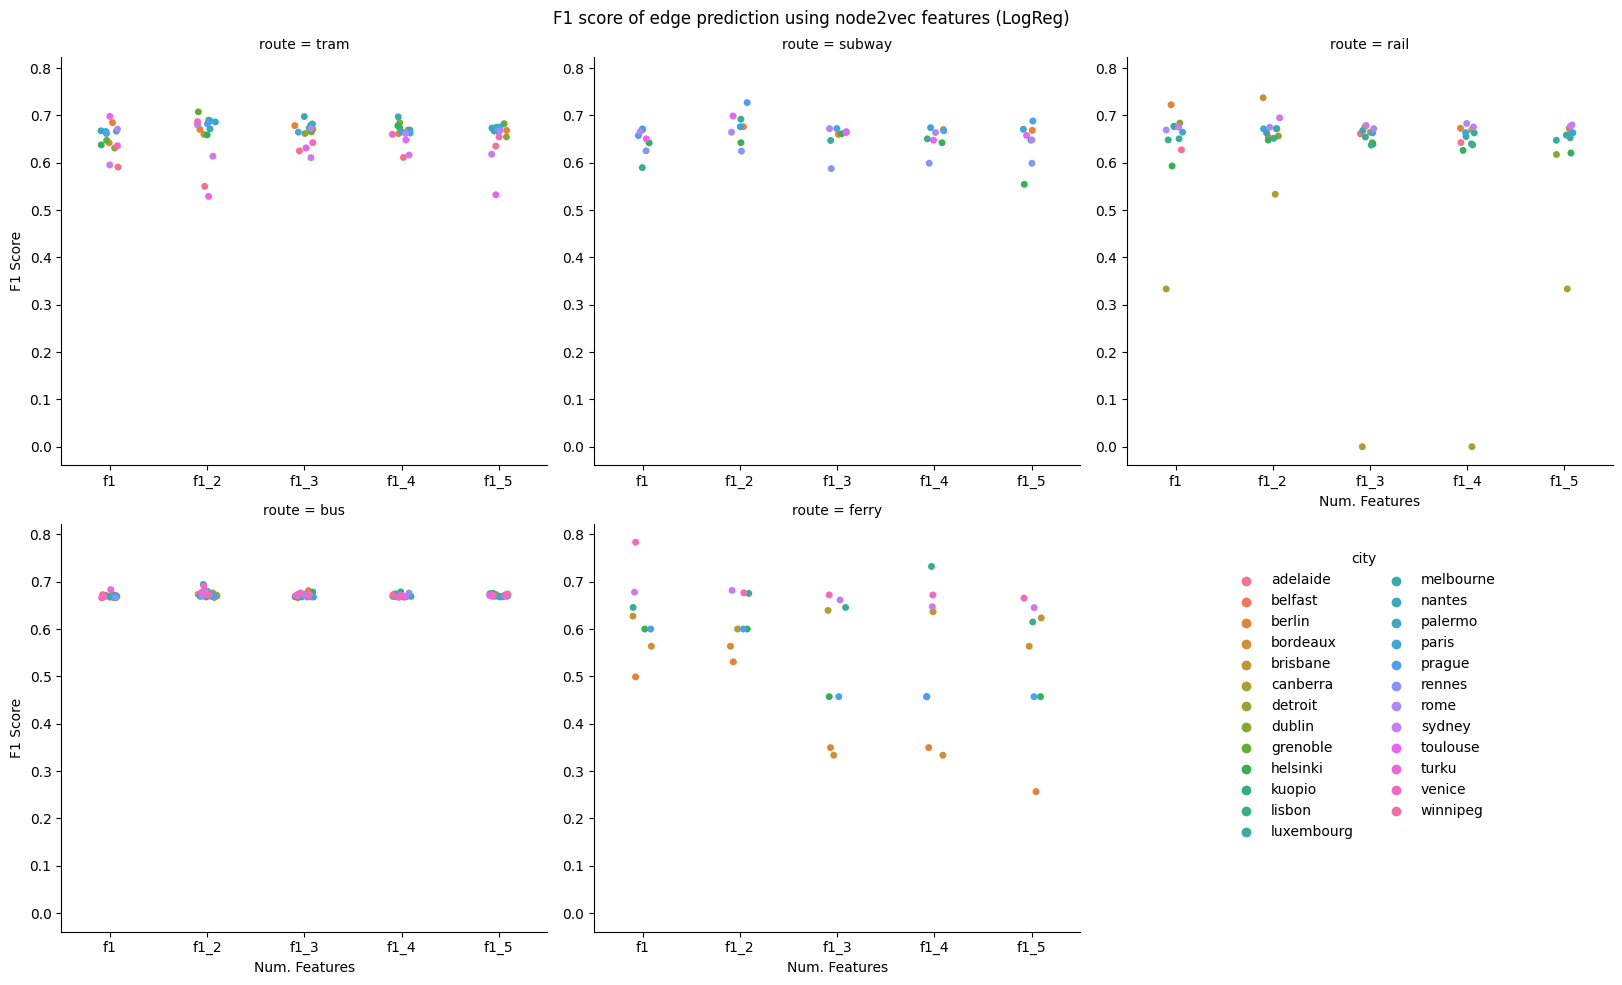

In [72]:
plt.figure(figsize=(12,10))
g = sns.catplot(t, x="num_features", y="f1_score", hue="city", col="route", col_wrap=3, sharey=True)
for ax in g.axes.flat:
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelbottom=True)

g.set_axis_labels("Num. Features", "F1 Score")
g.fig.suptitle("F1 score of edge prediction using node2vec features (LogReg)")
sns.move_legend(g, "upper left", bbox_to_anchor=(.75, .45), ncols=2)
plt.tight_layout()

plt.savefig(images_folder_path.joinpath('edge-pred-node2vec.eps'), format='eps')

In [73]:
f1_cols = ['f1', 'f1_2', 'f1_3', 'f1_4', 'f1_5', 'f1_6', 'f1_7',
       'f1_8', 'f1_9', 'f1_10']
combined_result_df['best'] = combined_result_df[f1_cols].idxmax(axis=1)
combined_result_df['best_score'] = combined_result_df[f1_cols].max(axis=1)

In [74]:
combined_result_df[["city", "route", "best"]].pivot(index='city', columns='route', values='best')

route,bus,ferry,rail,subway,tram
city,,,,,
adelaide,f1_2,NaN,f1_10,NaN,f1_5
belfast,f1_3,NaN,NaN,NaN,NaN
berlin,f1,f1_2,f1,f1_10,f1
bordeaux,f1_8,f1,NaN,NaN,f1_8
brisbane,f1_10,f1_8,f1_2,NaN,NaN
canberra,f1_10,NaN,f1_2,NaN,NaN
detroit,f1_10,NaN,NaN,NaN,NaN
dublin,f1_2,NaN,f1,NaN,f1_2
grenoble,f1_7,NaN,NaN,NaN,f1_2


In [75]:
combined_result_df[["city", "route", "best", "best_score"]].pivot(index='city', columns='route', values='best_score')

route,bus,ferry,rail,subway,tram
city,,,,,
adelaide,0.673486,NaN,0.666356,NaN,0.635206
belfast,0.681197,NaN,NaN,NaN,NaN
berlin,0.671749,0.530667,0.722335,0.680223,0.684734
bordeaux,0.672822,0.563636,NaN,NaN,0.678502
brisbane,0.670847,0.652220,0.737148,NaN,NaN
canberra,0.674662,NaN,0.533333,NaN,NaN
detroit,0.674003,NaN,NaN,NaN,NaN
dublin,0.675981,NaN,0.683716,NaN,0.689929
grenoble,0.676725,NaN,NaN,NaN,0.707411


In [76]:
a = combined_result_df[combined_result_df["route"] == "ferry"][["city"] + f1_cols]
a["mean"] = a[f1_cols].mean(axis=1)
a["std"] = a[f1_cols].std(axis=1)
a

,city,f1,f1_2,f1_3,f1_4,f1_5,f1_6,f1_7,f1_8,f1_9,f1_10,mean,std
typing.Literal[<no_default>],,,,,,,,,,,,,
4,adelaide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,belfast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,berlin,0.498901,0.530667,0.349495,0.349495,0.256566,0.387500,0.349495,0.324808,0.387500,0.324808,0.375923,0.082263
19,bordeaux,0.563636,0.563636,0.333333,0.333333,0.563636,0.333333,0.333333,0.333333,0.333333,0.333333,0.402424,0.111247
24,brisbane,0.627163,0.600036,0.639307,0.636327,0.623468,0.626491,0.632414,0.652220,0.627163,0.632414,0.629700,0.013334
29,canberra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,detroit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,dublin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,grenoble,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In this notebook, we use node2vec to do the edge prediction. Similar to the handcrafted features setup, we predict edges for each mode of transport in a city. We try with 1 to 10 features with p and q set at 1.0.

The performance of the node2vec for the bus networks drops significantly compared to the handcrafted features. The f1 scores for bus network are in the ball park of 0.67. The number of features do not show any effect on the f1 score on the bus network.

For the tram network, the performance improves for many cities. Similar to the bus network, the performance does not improve or drops with the increasing the number of features.

The node2vec features do not fare well for the rail network as well.

The node2vec features for the subway network perform similar to that of the node features considered earlier.

lastly, for the ferry network, we even see a drop in performance for some cities and other have the same level as using the handcrafted features.

Overall, we do not see the influence of number of features on the performance of the model. The node2vec features do not perform well for the bus, rail and ferry networks. The tram and subway networks perform similar to the handcrafted features.

However, this result did not tune the p,q parameters.